## Differentiation for postprocessing shear stress history

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\test_oscillations\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\conduit_flow\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [9]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [10]:
import io

In [11]:
# p = np.loadtxt("pressure.txt", delimiter=',')


In [12]:
# load from txt
# data_dir = "C:\\Users\\Fredric\\Downloads\\gaussianPulse_sig16_processed"
# os.chdir(data_dir)
# arhoFm = np.loadtxt("partialdensity_fragmented.txt", delimiter=',')
# p = np.loadtxt("pressure.txt", delimiter=',')

# load from pkl
data_dir = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\scenarios\free"
os.chdir(data_dir)
solver_from = lambda i, j: readwritedatafiles.read_data_file(
  f"conduit_sub{i}_{j}.pkl")
solver = solver_from(0,15080)

In [118]:
if False:
  ''' Load .txt (preprocessed output) '''
  z = np.loadtxt("depth.txt", delimiter=',')
  t = np.loadtxt("time.txt", delimiter=',')
  rho = np.loadtxt("density.txt", delimiter=',')
  tau = np.loadtxt("wall_trac.txt", delimiter=',')
  u = np.loadtxt("velocity.txt", delimiter=',')
  vf = np.loadtxt("gas_volfrac.txt", delimiter=',')

(-550.0, -475.0)

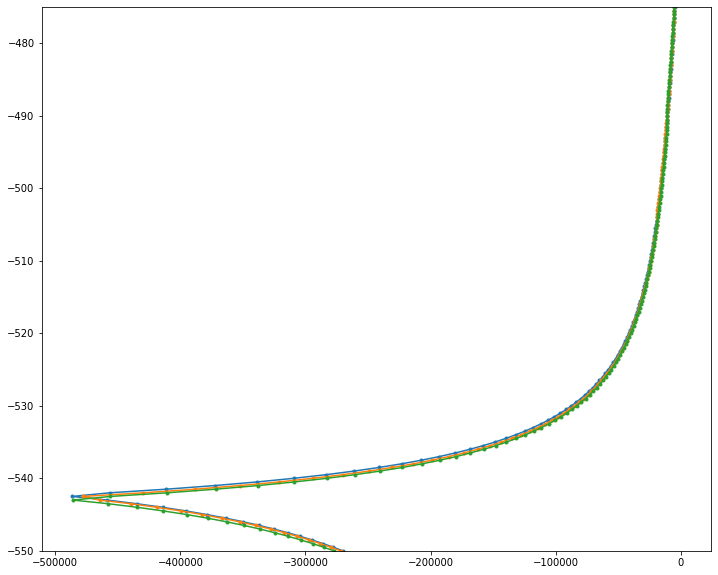

In [219]:
''' Show shear stress tau(x) '''
plt.figure(figsize=(12,10))
plt.plot(tau[...,10000], z, '.-')
plt.plot(tau[...,11000], z, '.-')
plt.plot(tau[...,12000], z, '.-')
plt.ylim(-550,-475)

C:\Users\Fredric\AppData\Local\Temp\ipykernel_9976\1036181698.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(mg_z[::100,1500:], mg_t[::100,1500:], np.log10(np.abs(u[1500:,::100]-u[1500:,0:1])).T, levels=200)


Text(0, 0.5, 'Time (s)')

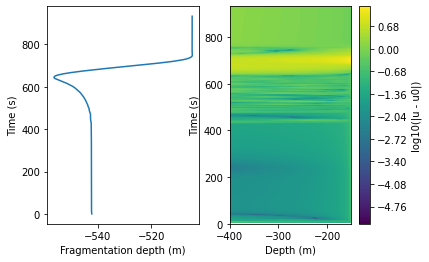

In [133]:
# plt.plot(z,vf[:,15000])
fragz7 = [np.interp(0.7, vf[:, _idx_t], z) for _idx_t in range(vf.shape[1])]
plt.plot(fragz7)

mg_z, mg_t = np.meshgrid(z, t, indexing="xy")
plt.subplot(1,2,1)
plt.plot(fragz7, t)
plt.xlabel("Fragmentation depth (m)")
plt.ylabel("Time (s)")

plt.subplot(1,2,2)
plt.contourf(mg_z[::100,1500:], mg_t[::100,1500:], np.log10(np.abs(u[1500:,::100]-u[1500:,0:1])).T, levels=200)
plt.colorbar(label="log10(|u - u0|)")
plt.xlabel("Depth (m)")
plt.ylabel("Time (s)")


Text(0.5, 1.0, 'Position shifted by -40 m for t = 920.00 curve')

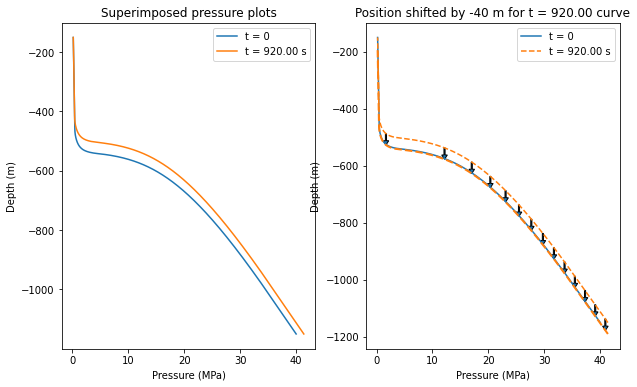

In [193]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(p[:,0]/1e6,z)
plt.plot(p[:,23000]/1e6,z)
plt.legend([f"t = 0", f"t = {t[23000]:.2f} s"])
plt.xlabel("Pressure (MPa)")
plt.ylabel("Depth (m)")
plt.title("Superimposed pressure plots")

plt.subplot(1,2,2)
plt.plot(p[:,0]/1e6,z)
# Save pressure at t
p_t_MPa = p[:,23000]/1e6
plt.plot(p_t_MPa, z, '--')
arrows = [plt.arrow(p_t_MPa[_i], z[_i], 0, -40, width=0.2, head_width=1, head_length=15, length_includes_head=True)
  for _i in np.arange(25, len(p_t_MPa)-600, 100)]
plt.plot(p_t_MPa, z-40, '--', color="C1", linewidth=2)
plt.legend([f"t = 0", f"t = {t[23000]:.2f} s"])
plt.xlabel("Pressure (MPa)")
plt.ylabel("Depth (m)")
plt.title(f"Position shifted by -40 m for t = {t[23000]:.2f} curve")

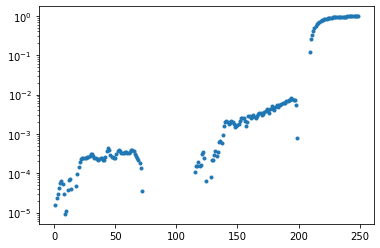

In [48]:
plt.semilogy((p/rho)[1000:1250,14000], '.')


(-0.0001, 0.0001)

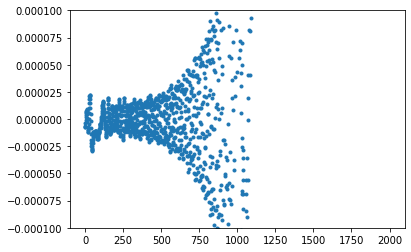

In [78]:
# plt.semilogy((p/rho)[1000:1250,17000], '.')
plt.plot((p/rho)[:,19000], '.')
plt.ylim(-1e-4, 1e-4)

In [76]:
t_signal = (p/rho)[:,19000]
moving_avg = np.convolve(t_signal, np.ones(9)/9.0, 'same')

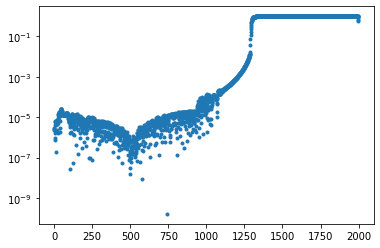

In [77]:
plt.semilogy(np.abs(moving_avg), '.')


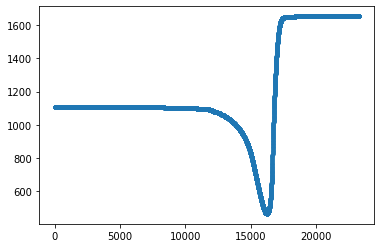

In [33]:
plt.plot(rho[1200,::1], '.')


## Spatial limiting: synthetic test case

In [73]:
# solver = readwritedatafiles.read_data_file(
#   f"conduitSteadyState_inlet_0.pkl")
# solver = readwritedatafiles.read_data_file(
#   f"debug_odestart_consistency_0.pkl")


ElementOrder 2


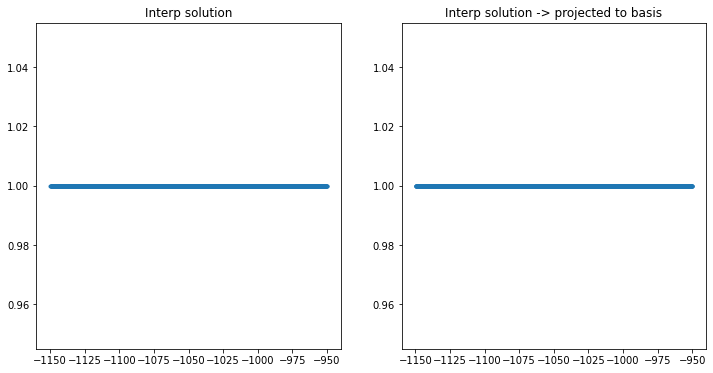

In [13]:
from scipy.special import erf

# Synthetic traveling wave solution
def soln(x, t, x0=-1501.5, scale=1e-2):
  c = 1
  return erf((x - x0 - c * t)/scale)

def soln_L2proj(x, t, solver, x0=-1501.5, scale=1e-2):
  elem_helpers = solver.elem_helpers
  basis_val = elem_helpers.basis_val
  iMM_elems = elem_helpers.iMM_elems
  quad_pts = elem_helpers.quad_pts
  quad_wts = elem_helpers.quad_wts
  x_elems = elem_helpers.x_elems

  interp_vals = soln(x, t, x0=x0, scale=scale)
  _out_array = np.zeros_like(interp_vals)
  solver_tools.L2_projection(solver.mesh, iMM_elems, solver.basis,
            quad_pts, quad_wts, interp_vals, _out_array)
  return _out_array

x_elems = solver.elem_helpers.x_elems
interp_vals = soln(x_elems, 0.0)
proj_vals = soln_L2proj(x_elems, 0.0, solver)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_elems.ravel(), interp_vals.ravel(), '.-')
plt.title("Interp solution")
plt.subplot(1,2,2)
plt.plot(x_elems.ravel(), proj_vals.ravel(), '.-')
plt.title("Interp solution -> projected to basis")
print(f"ElementOrder {solver.order}")

(0, 399)

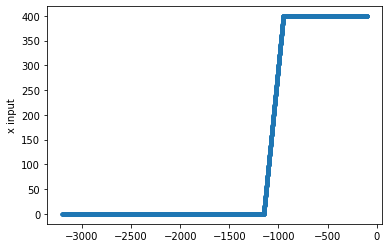

In [14]:
''' Define indexing function '''
def elt_index(x_in, node_coords):
  ''' Maps location to element index '''
  if x_in <= node_coords[0]:
    return 0
  if x_in >= node_coords[-1]:
    return node_coords.shape[0]-2
  return node_coords.shape[0] \
    - np.argmax((x_in >= node_coords)[::-1]) - 1

''' Test indexing function '''
test_locations = np.linspace(-3200, -100, 12340)
test_indices = np.array([elt_index(_x, solver.mesh.node_coords) for _x in test_locations])
plt.plot(test_locations, test_indices, '.')
plt.ylabel("Element index")
plt.ylabel("x input")

(test_indices.min(), test_indices.max())

In [15]:
''' Construct piecewise interpolator '''
import scipy.interpolate

def eval_soln(x, x_elems, proj_vals, node_coords):
  ''' Evaluates piecewise polynomial solution without filtering. '''
  # Wrap x in array if scalar
  x = np.asarray(x)
  y = np.empty_like(x)
  # Piecewise evaluation
  for i, _x in enumerate(x.ravel()):
    # JIT interpolation construction from scipy lagrange interp interface
    _elt_idx = elt_index(_x, node_coords)
    _poly = scipy.interpolate.lagrange(
      x_elems[_elt_idx,:,0].ravel(),
      proj_vals[_elt_idx,:,0])
    y.ravel()[i] = _poly(_x)
  return y

In [16]:
''' Construct piecewise interpolator with limiting filter
This filter forces each interior element's polynomial to be bounded by the means
of its two neighbours. '''

def compute_elem_avg(x_elems, vals, node_coords):
  # Compute element-average value by polynomial integration
  avg_vals = np.empty(x_elems[:,0:1,:].shape)
  avg_vals.ravel()[:] = np.array([np.diff(scipy.interpolate.lagrange(
    x_elems[i,:,0].ravel(),
    vals[i,:,0]).integ()(node_coords[i:i+2,...]).ravel()) / (
        node_coords[i+1,...] - node_coords[i,...]
    ) for i in range(x_elems.shape[0])]).ravel()
  return avg_vals

def compute_poly_coef(x_elems, vals, node_coords, limiting_factor=1.0):
  ''' Compute polynomial coefficients of a piecewise quadratic (P2 polynomial
  basis). Valid for scalar quantities.
  Inputs:
    x_elems:np.array with shape (ne, 3, 1); x-location of nodal points
    vals:np.array with shape (ne, 3, 1); scalar value at each entry in x_elems
    node_coords: (ne+1, 1): location of element boundaries (mesh-nodes)
  Outputs:
    poly_coeff: np.array with shape (ne, 3, 1)
  '''
  # Compute element-average value by polynomial integration
  avg_vals = np.empty(x_elems[:,0:1,:].shape)
  avg_vals.ravel()[:] = np.array([np.diff(scipy.interpolate.lagrange(
    x_elems[i,:,0].ravel(),
    vals[i,:,0]).integ()(node_coords[i:i+2,...]).ravel()) / (
        node_coords[i+1,...] - node_coords[i,...]
    ) for i in range(x_elems.shape[0])]).ravel()
  # Allocate
  poly_coeffs = np.zeros((x_elems.shape[0], vals.shape[1], 1))
  _debug_scaling_factors = np.ones((x_elems.shape[0],))
  # Interior element limiting
  for i in range(x_elems.shape[0]):
    # Construct local polynomial from interpolating nodal values
    _poly = scipy.interpolate.lagrange(
          x_elems[i,:,0].ravel(),
          vals[i,:,0])
    # Rescale local polynomial for interior element
    if i != 0 and i != x_elems.shape[0]-1:
      # Get possible extremizers for quadratic (critical point, endpoints)
      _dpoly = _poly.deriv()
      x_extr = np.array([node_coords[i,0], node_coords[i+1,0], 0])
      x_extr[2] = np.clip(-_dpoly[1] / _dpoly[0],
                          x_extr[0], x_extr[1]) if _dpoly[0] != 0 else 0
      # Assemble means in adjacent elements
      adjacent_means = np.array((avg_vals[i-1,0,0], avg_vals[i+1,0,0]))
      # Compute local solution scaling factor for overshooting adjacent means
      scaling_factor = np.clip(np.minimum(
        (adjacent_means.min() - avg_vals[i,0,0]) \
          / (-1e-11 + _poly(x_extr).min() - avg_vals[i,0,0]), \
        (adjacent_means.max() - avg_vals[i,0,0]) \
          / (1e-11 + _poly(x_extr).max() - avg_vals[i,0,0])),
        0, 1)
      # External control (for debug)
      scaling_factor = limiting_factor * scaling_factor + (1 - limiting_factor)
      # Apply scaling to nodal values
      scaled_nodes = avg_vals[i,0,0] \
        + scaling_factor * (vals[i,:,0] - avg_vals[i,0,0])
      # Refit polynomial (coefficients in DECREASING degree)
      _poly = scipy.interpolate.lagrange(
        x_elems[i,:,0].ravel(),
        scaled_nodes)
      _debug_scaling_factors[i] = scaling_factor
    # Force fit polynomial to be degree 2
    poly_coeffs_decreasing = np.zeros((3,))
    poly_coeffs_decreasing[-_poly.coef.size:] = _poly.coef
    # Save polynomial coefficients for np.polynomial.polynomial.Polynomial, in
    #   INCREASING degree
    poly_coeffs[i,:,0] = poly_coeffs_decreasing[::-1]
    
  return poly_coeffs

def eval_soln_limited(x, poly_coeffs, node_coords):
  ''' Evaluates piecewise polynomial solution with limiting/filtering. '''
  # Wrap x in array if scalar
  x = np.asarray(x)
  y = np.empty_like(x)
  # Piecewise evaluation
  for i, _x in enumerate(x.ravel()):
    _elt_idx = elt_index(_x, node_coords)
    _poly = np.polynomial.polynomial.Polynomial(poly_coeffs[_elt_idx].ravel())
    y.ravel()[i] = _poly(_x)
  return y

In [17]:
_pc = compute_poly_coef(x_elems, proj_vals, solver.mesh.node_coords)
_pc.shape

(400, 3, 1)

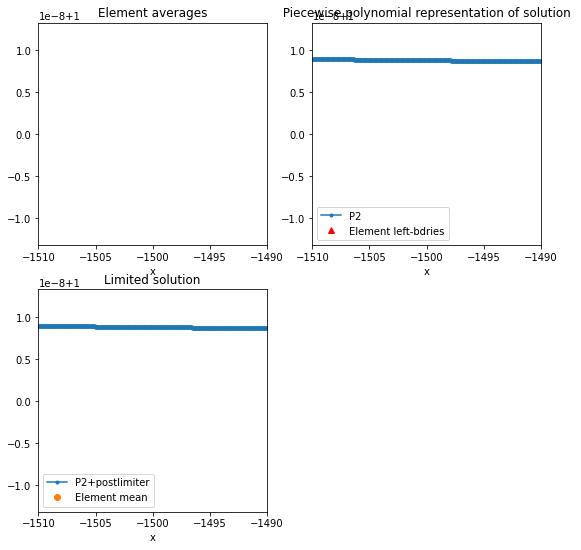

In [18]:
''' Plot different interpretations of solution vector '''

# Set sampling range
x_sample = np.linspace(-1510, -1490, 500)
u_sample = eval_soln(x_sample, x_elems, proj_vals, solver.mesh.node_coords)
poly_coeffs = compute_poly_coef(x_elems, proj_vals, solver.mesh.node_coords)
u_sample_limited = eval_soln_limited(x_sample, poly_coeffs, solver.mesh.node_coords)

avg_vals = compute_elem_avg(x_elems, proj_vals, solver.mesh.node_coords)
                 
plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.plot(x_elems[:,1,0], avg_vals.ravel(), 'o')
plt.title("Element averages")
plt.xlim(x_sample[[0,-1]])
plt.xlabel("x")

plt.subplot(2,2,2)
plt.plot(x_sample, u_sample, '.-')
# Overlay element boundaries
plt.plot(
  solver.mesh.node_coords.ravel(),
  eval_soln(solver.mesh.node_coords.ravel(),
            x_elems, proj_vals, solver.mesh.node_coords),
  'r^')
plt.title(''' Piecewise polynomial representation of solution ''')
plt.xlim(x_sample[[0,-1]])
plt.xlabel("x")
plt.legend(["P2", "Element left-bdries"])

plt.subplot(2,2,3)
plt.plot(x_sample, u_sample_limited, '.-')
# Overlay element centers
plt.plot(x_elems[:,1,0], avg_vals.ravel(), 'o')
plt.xlim(x_sample[[0,-1]])
plt.xlabel("x")
plt.title("Limited solution")
plt.legend(["P2+postlimiter", "Element mean"])


Text(0.5, 0, 'x')

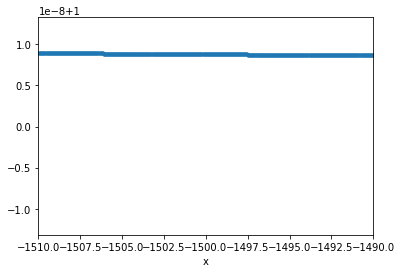

In [19]:
''' Show unlimited polynomial representation of solution '''
x_sample = np.linspace(-1510, -1490, 500)
u_sample = eval_soln(x_sample, x_elems, proj_vals, solver.mesh.node_coords)
plt.plot(x_sample, u_sample, '.-')
plt.plot(
  solver.mesh.node_coords.ravel(),
  eval_soln(solver.mesh.node_coords.ravel(), x_elems, proj_vals, solver.mesh.node_coords),
  'r^')
plt.xlim(x_sample[[0,-1]])
plt.xlabel("x")

Default erf x-scale is 0.01, advection speed 1. Expect d/dt ~ -u/scale ~ 100. Expect factor of 2 from amplitude of erf (-1,1).


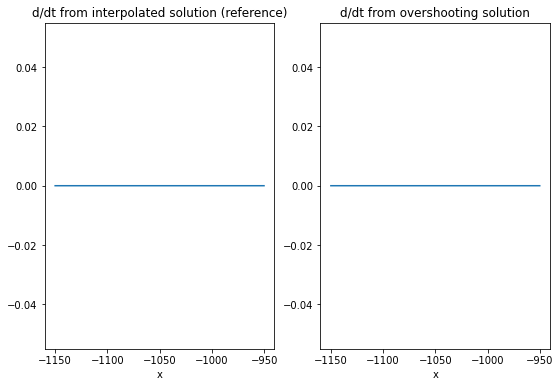

In [20]:
# Basic d/dt
dt = 1e-7

# Interpolated reference solution
du_ref = (soln(x_elems, dt) - soln(x_elems, 0.0))/dt
# Simulate overshooting solution
du = (soln_L2proj(x_elems, dt, solver) - soln_L2proj(x_elems, 0.0, solver))/dt
# # Limited reconstruction on overshooting solution
# du_limited = (eval_soln_limited(x_elems, poly_coeffs, solver.mesh.node_coords) \
#               -eval_soln_limited(x_elems, poly_coeffs, solver.mesh.node_coords))

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(x_elems.ravel(), du_ref.ravel())
plt.xlabel("x")
plt.title("d/dt from interpolated solution (reference)")
plt.subplot(1,3,2)
plt.plot(x_elems.ravel(), du.ravel())
plt.xlabel("x")
plt.title("d/dt from overshooting solution")
# plt.subplot(1,3,3)
# plt.plot(x_elems.ravel(), du_limited.ravel())
# plt.xlabel("x")
# plt.title("d/dt from limited overshooting solution")
print("Default erf x-scale is 0.01, advection speed 1. Expect d/dt ~ -u/scale ~ 100. Expect factor of 2 from amplitude of erf (-1,1).")

## Test on simulation output (reference solution)

In [462]:
solver1 = readwritedatafiles.read_data_file(
  f"debug_odestart_consistency_1000.pkl")
solver2 = readwritedatafiles.read_data_file(
  f"debug_odestart_consistency_1001.pkl")
dt = solver2.time - solver1.time
solver1.time, solver1.order, dt

(114.28571428696158, 2, 0.11428571428950818)

In [471]:
''' Compute spatial limiting '''
x_sample = np.linspace(solver1.mesh.node_coords.min(),
                       solver1.mesh.node_coords.max(),
                       12000)
val_t1 = eval_soln_limited(x_sample,
                           compute_poly_coef(solver1.elem_helpers.x_elems,
                                             solver1.state_coeffs[...,3:4],
                                             solver1.mesh.node_coords),
                           solver1.mesh.node_coords)
val_t2 = eval_soln_limited(x_sample,
                           compute_poly_coef(solver2.elem_helpers.x_elems,
                                             solver2.state_coeffs[...,3:4],
                                             solver2.mesh.node_coords),
                           solver2.mesh.node_coords)

In [491]:
''' Compute forward Euler d/dt of momentum equation '''

dvdt_nofilter = (solver2.state_coeffs[...,3:4] \
                 - solver1.state_coeffs[...,3:4]) / dt
dvdt_limited = (val_t2 - val_t1) / dt

dvdt_postlimited = eval_soln_limited(x_sample,
  compute_poly_coef(solver2.elem_helpers.x_elems,
                    solver2.state_coeffs[...,3:4]-solver1.state_coeffs[...,3:4],
                    solver2.mesh.node_coords),
  solver2.mesh.node_coords) / dt

In [492]:
dvdt_postlimited

array([ 0.093545484266165,  0.005974974337534, -0.022717334503951, ...,
        0.10794877780145 ,  0.108937559326963,  0.109697627896755])

Text(0.5, 1.0, 'd/dt -> postprocess limiter')

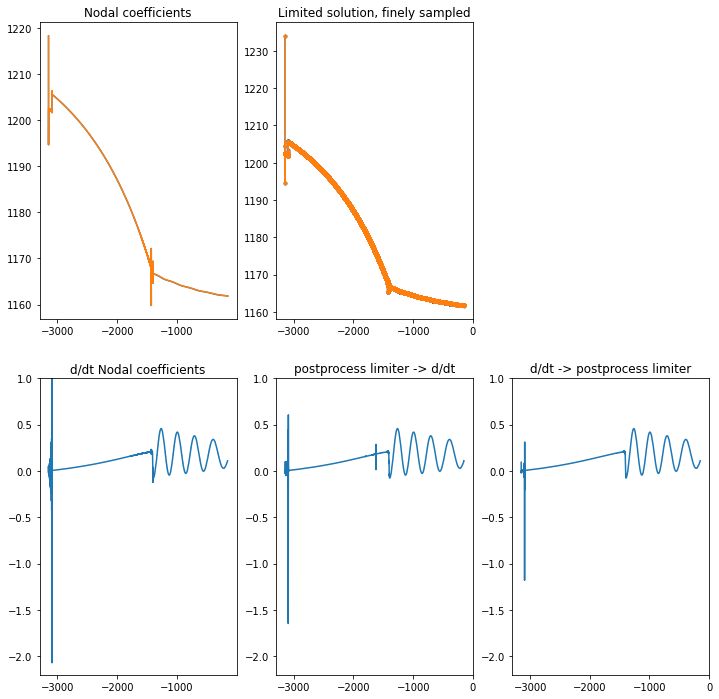

In [495]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
plt.plot(solver1.elem_helpers.x_elems.ravel(), solver1.state_coeffs[...,3:4].ravel())
plt.plot(solver2.elem_helpers.x_elems.ravel(), solver2.state_coeffs[...,3:4].ravel())
plt.title("Nodal coefficients")
plt.subplot(2,3,2)
plt.plot(x_sample, val_t1, '.-')
plt.plot(x_sample, val_t2, '.-')
plt.title("Limited solution, finely sampled")
plt.subplot(2,3,4)
plt.plot(solver1.elem_helpers.x_elems.ravel(), dvdt_nofilter.ravel())
plt.ylim(-2.2, 1.0)
plt.title("d/dt Nodal coefficients")
plt.subplot(2,3,5)
plt.plot(x_sample, dvdt_limited)
plt.ylim(-2.2, 1.0)
plt.title("postprocess limiter -> d/dt")
plt.subplot(2,3,6)
plt.plot(x_sample, dvdt_postlimited)
plt.ylim(-2.2, 1.0)
plt.title("d/dt -> postprocess limiter")

In [488]:
plt.clf()
plt.plot(x_sample, val_t1)
plt.plot(x_sample, val_t2)
# plt.plot(x_sample, (val_t2 - val_t1)/val_t1)
plt.xlim(-1624, -1620)
plt.ylim(1170,1180)

(1170.0, 1180.0)

#### Unused

In [101]:
# (helpers.evaluate_state(_out_array, solver.basis.basis_val)).shape, _out_array.shape

((3000, 3, 1), (3000, 3, 1))

## Test on simulation output (production)

In [21]:
solver1 = solver_from(3,15080)
solver2 = solver_from(3,15081)

In [22]:
''' Compute spatial limiting '''
x_sample = np.linspace(solver1.mesh.node_coords.min(),
                       solver1.mesh.node_coords.max(),
                       12000)
val_t1 = eval_soln_limited(x_sample,
                           compute_poly_coef(solver1.elem_helpers.x_elems,
                                             solver1.state_coeffs[...,3:4],
                                             solver1.mesh.node_coords),
                           solver1.mesh.node_coords)
val_t2 = eval_soln_limited(x_sample,
                           compute_poly_coef(solver2.elem_helpers.x_elems,
                                             solver2.state_coeffs[...,3:4],
                                             solver2.mesh.node_coords),
                           solver2.mesh.node_coords)

In [23]:
''' Compute forward Euler d/dt of momentum equation '''

dvdt_nofilter = (solver2.state_coeffs[...,3:4] \
                 - solver1.state_coeffs[...,3:4]) / dt
dvdt_limited = (val_t2 - val_t1) / dt

dvdt_postlimited = eval_soln_limited(x_sample,
  compute_poly_coef(solver2.elem_helpers.x_elems,
                    solver2.state_coeffs[...,3:4]-solver1.state_coeffs[...,3:4],
                    solver2.mesh.node_coords),
  solver2.mesh.node_coords) / dt

Text(0.5, 1.0, 'd/dt -> postprocess limiter')

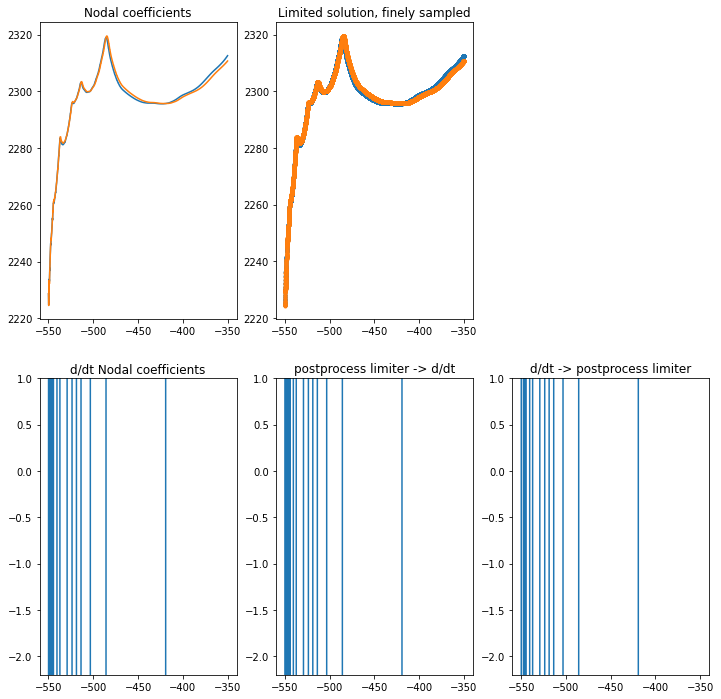

In [24]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
plt.plot(solver1.elem_helpers.x_elems.ravel(), solver1.state_coeffs[...,3:4].ravel())
plt.plot(solver2.elem_helpers.x_elems.ravel(), solver2.state_coeffs[...,3:4].ravel())
plt.title("Nodal coefficients")
plt.subplot(2,3,2)
plt.plot(x_sample, val_t1, '.-')
plt.plot(x_sample, val_t2, '.-')
plt.title("Limited solution, finely sampled")
plt.subplot(2,3,4)
plt.plot(solver1.elem_helpers.x_elems.ravel(), dvdt_nofilter.ravel())
plt.ylim(-2.2, 1.0)
plt.title("d/dt Nodal coefficients")
plt.subplot(2,3,5)
plt.plot(x_sample, dvdt_limited)
plt.ylim(-2.2, 1.0)
plt.title("postprocess limiter -> d/dt")
plt.subplot(2,3,6)
plt.plot(x_sample, dvdt_postlimited)
plt.ylim(-2.2, 1.0)
plt.title("d/dt -> postprocess limiter")

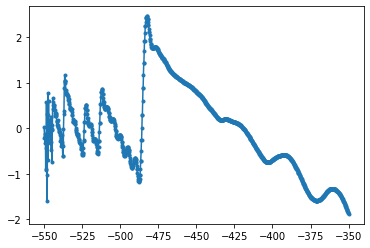

In [28]:
plt.plot(solver1.elem_helpers.x_elems.ravel(), solver2.state_coeffs[...,3:4].ravel() - solver1.state_coeffs[...,3:4].ravel(), '.-')


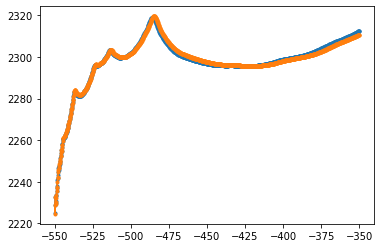

In [27]:
''' Solution views '''
plt.plot(solver1.elem_helpers.x_elems.ravel(), solver1.state_coeffs[...,3:4].ravel(), '.-')
plt.plot(solver2.elem_helpers.x_elems.ravel(), solver2.state_coeffs[...,3:4].ravel(), '.-')


In [29]:
# Define convenience bindings
physics = solver1.physics
_get = lambda name: physics.compute_additional_variable(name, solver1.state_coeffs, False)

plt.plot(solver1.elem_helpers.x_elems.ravel(), _get("Pressure").ravel(), '.-')


In [43]:
  np.polynomial.polynomial.Polynomial(_poly_coef[100].ravel())

Polynomial([5.940129246711731e+04, 2.278581236749887e+02,
       2.273181093623862e-01], domain=[-1,  1], window=[-1,  1])

Text(0, 0.5, 'd/dx(momentum) intraelement')

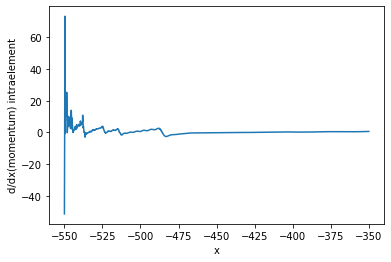

In [219]:
''' Proper differentiation '''

def eval_ddx_soln(x, poly_coeffs, node_coords, order=1):
  ''' Evaluates nth derivative of piecewise polynomial solution from monomial
  basis coefficients. Input order can be zero. '''
  # Wrap x in array if scalar
  x = np.asarray(x)
  y = np.empty_like(x)
  # Piecewise evaluation
  for i, _x in enumerate(x.ravel()):
    _elt_idx = elt_index(_x, node_coords)
    _poly = np.polynomial.polynomial.Polynomial(poly_coeffs[_elt_idx].ravel())
    y.ravel()[i] = _poly.deriv(order)(_x)
  return y

_poly_coef = compute_poly_coef(solver1.elem_helpers.x_elems,
    solver1.state_coeffs[...,3:4],
    solver1.mesh.node_coords)

plt.plot(solver1.elem_helpers.x_elems.ravel(),
         eval_ddx_soln(solver1.elem_helpers.x_elems,
              _poly_coef,
              solver1.mesh.node_coords,
              order=1).ravel())
plt.xlabel("x")
plt.ylabel("d/dx(momentum) intraelement")


In [102]:
# Evaluate derivative at dof points
dU = np.concatenate([eval_ddx_soln(solver1.elem_helpers.x_elems,
  compute_poly_coef(solver1.elem_helpers.x_elems,
      solver1.state_coeffs[...,i:i+1],
      solver1.mesh.node_coords),
      solver1.mesh.node_coords) for i in range(solver1.state_coeffs.shape[-1])],
      axis=-1)

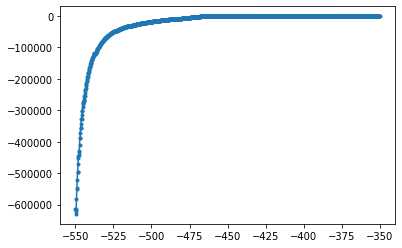

In [156]:
# Compute pressure gradient dpdx with chain rule
dp = np.expand_dims(np.einsum("ijk, ijk -> ij",
  solver1.physics.compute_pressure_sgradient(solver1.state_coeffs),
  dU), axis=-1)
plt.plot(solver1.elem_helpers.x_elems.ravel(), dp.ravel(), '.-')

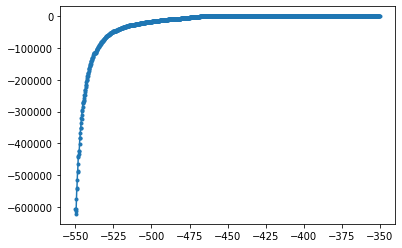

In [157]:
# Compute hydrostatics
rho = solver1.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
dp_rel = dp + rho * 9.8
plt.plot(solver1.elem_helpers.x_elems.ravel(), dp_rel.ravel(), '.-')

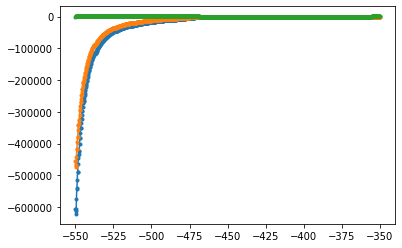

In [106]:
""" Plot approximate components of momentum residual """
tau = _get("Drag")

plt.plot(solver1.elem_helpers.x_elems.ravel(), dp_rel.ravel(), '.-')
plt.plot(solver1.elem_helpers.x_elems.ravel(), tau.ravel(), '.-')

# Momentum advection term through calculus
dmomentum = 2 * solver1.state_coeffs[...,3:4] / rho * dU[...,3:4] \
  - solver1.state_coeffs[...,3:4]**2 / (rho*rho) * dU[...,0:3].sum(axis=-1, keepdims=True)
plt.plot(solver1.elem_helpers.x_elems.ravel(), dmomentum.ravel(), '.-')


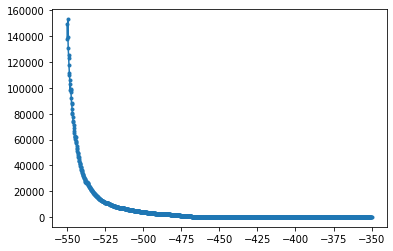

In [218]:
# Momentum pointwise residual, excluding pressure inter-element jumps
plt.plot(solver1.elem_helpers.x_elems.ravel(), (-dp_rel - dmomentum + tau).ravel(), '.-')

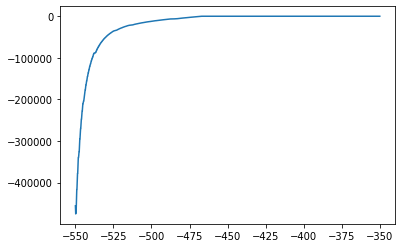

In [216]:
""" Evaluate source term ([1] is drag), and should == tau"""
S = solver1.physics.source_terms[1].get_source(
  solver1.physics,
  solver1.state_coeffs,
  solver1.elem_helpers.x_elems,
  solver1.time)
# Check S == tau
# plt.plot(solver1.elem_helpers.x_elems[...].ravel(), (S[...,3:4]-tau).ravel())
plt.plot(solver1.elem_helpers.x_elems[...].ravel(), S[...,3:4].ravel())

Numerical differentiation of p on interped grid is not feasible.


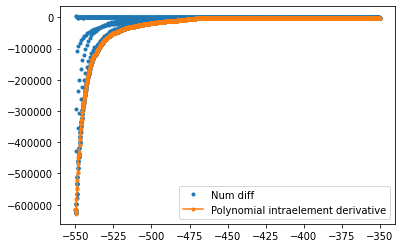

In [215]:
# Check p and dp/dx consistency
# plt.plot(solver1.elem_helpers.x_elems[...].ravel()[1:],
  # scipy.integrate.cumtrapz(dp.ravel(), x=solver1.elem_helpers.x_elems[...].ravel()) + _get("Pressure").ravel()[0])

x_interp = np.linspace(solver1.elem_helpers.x_elems[...].min(),
                       solver1.elem_helpers.x_elems[...].max(), 5000)
p_interp = np.interp(x_interp,
                     solver1.elem_helpers.x_elems[...].ravel(),
                     _get("Pressure").ravel())
dpdx_approx = np.diff(p_interp) / (x_interp[1] - x_interp[0])

plt.figure()
plt.plot(x_interp[1:], dpdx_approx, '.')
plt.plot(solver1.elem_helpers.x_elems[...].ravel(), dp.ravel(), '.-')
plt.legend(["Num diff", "Polynomial intraelement derivative"])
print("Numerical differentiation of p on interped grid is not feasible.")

Momentum residual from the numerics, before limiting


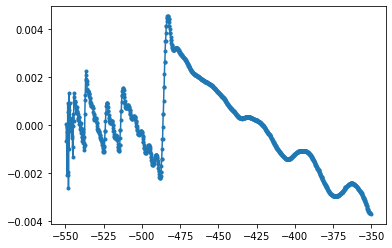

In [217]:
U = solver1.state_coeffs.copy()
res = np.zeros_like(U)
# Get residual without boundary_face_residuals
solver1.get_element_residuals(U, res)
solver1.get_interior_face_residuals(U, res)
numerical_res = solver_tools.mult_inv_mass_matrix(solver1.mesh, solver1, solver1.stepper.dt, res)

plt.plot(solver1.elem_helpers.x_elems[1:-1,...].ravel(),
  numerical_res[1:-1,...,3:4].ravel(), '.-')
print("Momentum residual from the numerics, before limiting")

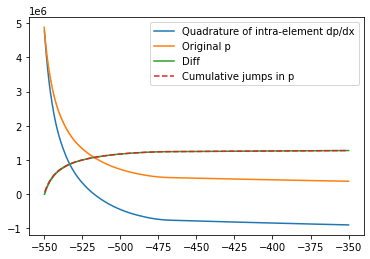

In [211]:
''' Compare integral of pressure gradient with original pressure info; the
difference is the cumulative pressure jumps between elements. This suggests
that the pointwise dp/dx may not be a good representation of the solution. '''

# Collect pressure jumps 
p_L = np.zeros(poly_coef_U.shape[0])
p_R = np.zeros(poly_coef_U.shape[0])
for i in range(poly_coef_U.shape[0]): # for each element
  # Evaluate pressure at endpoints
  x_L, x_R = solver1.mesh.node_coords[i], solver1.mesh.node_coords[i+1]
  U_endpoints = np.array([np.polynomial.polynomial.Polynomial(
         poly_coef_U[i,...,state_idx].ravel())(np.array([x_L, x_R]))
       for state_idx in range(poly_coef_U.shape[-1])]).T
  p_L[i], p_R[i] = physics.compute_variable("Pressure", U_endpoints).ravel()

# Plot p jumps at interior faces
# plt.plot(p_L[1:]-p_R[:-1], '.')

# Numerically integrated dp/dx + constant
diff_integ_p = scipy.integrate.cumtrapz(dp.ravel(),
                           x=solver1.elem_helpers.x_elems[...].ravel()) \
    + _get("Pressure").ravel()[0]
plt.plot(solver1.elem_helpers.x_elems[...].ravel()[1:], diff_integ_p)

# Plot pressure computed at nodes
plt.plot(solver1.elem_helpers.x_elems[...].ravel(), _get("Pressure").ravel())

# Plot diff of integrated dp/dx + constant and pressure
plt.plot(solver1.elem_helpers.x_elems[...].ravel()[1:],
  _get("Pressure").ravel()[1:] - diff_integ_p.ravel())
# Plot cumulative pressure jump
plt.plot(solver1.mesh.node_coords[1:-1], np.cumsum(p_L[1:]-p_R[:-1]), '--')

plt.legend(["Quadrature of intra-element dp/dx", "Original p", "Diff", "Cumulative jumps in p"])

## Shear study

In [257]:
solver1 = solver_from(3,15080)
solver2 = solver_from(3,15081)
dt = solver2.time - solver1.time

In [268]:
file_idx = 15080
globaldrag = np.concatenate([_get_from(solver_from(i, file_idx), "Drag") \
  for i in (1,2,3,4)], axis=0)
diffdrag = np.concatenate([_get_from(solver_from(i, file_idx+1), "Drag") \
  - _get_from(solver_from(i, file_idx), "Drag") for i in (0,1,2,3,4)], axis=0)
x_elems = np.concatenate([solver_from(i, file_idx).elem_helpers.x_elems for i in (0,1,2,3,4)], axis=0)

In [235]:
x_elems.shape, diffdrag.shape

((1600, 3, 1), (1600, 3, 1))

In [238]:
diffdrag.shape

(1600, 3, 1)

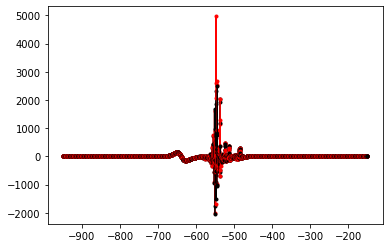

In [246]:
''' Solution views '''
_get_from = lambda solver, name: solver.physics.compute_variable(name, solver.state_coeffs)
colorcycle = ["red", "black"]
for i in range(x_elems.shape[0]):
  plt.plot(x_elems[i,...].ravel(), diffdrag[i,...].ravel(), '.-', color=colorcycle[i % 2])
  # plt.plot(x_elems[i,...].ravel(), globaldrag[i,...].ravel(), '.-', color=colorcycle[i % 2])
# plt.xlim(-560, -530)


In [253]:
diffdrag.shape, x_elems.shape

((1600, 3, 1), (1600, 3, 1))

In [262]:
solver1.physics.source_terms[1].conduit_radius

50

6380124.536361465

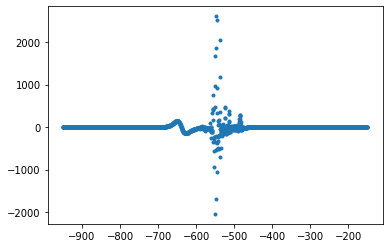

In [263]:
''' Integration of diffdrag '''
plt.plot(x_elems[:,0], diffdrag[:,0,0], '.')
np.trapz(diffdrag[:,0,0].ravel(), x=x_elems[:,0].ravel()) * 2 * np.pi \
   * solver1.physics.source_terms[1].conduit_radius / dt

In [279]:
''' Time series of integral of diffdrag '''
force_rate_reduced = []
force_reduced = []
t_list = []
for file_idx in range(15000, 15099):
  diffdrag = np.concatenate([_get_from(solver_from(i, file_idx+1), "Drag") \
    - _get_from(solver_from(i, file_idx), "Drag") for i in (0,1,2,3,4)], axis=0)
  globaldrag = np.concatenate([_get_from(solver_from(i, file_idx), "Drag") \
     for i in (0,1,2,3,4)], axis=0)
  force_rate_reduced.append(np.trapz(diffdrag[:,0,0].ravel(), x=x_elems[:,0].ravel()) * 2 * np.pi \
    * solver1.physics.source_terms[1].conduit_radius / dt)
  force_reduced.append(np.trapz(globaldrag[:,0,0].ravel(), x=x_elems[:,0].ravel()) * 2 * np.pi \
    * solver1.physics.source_terms[1].conduit_radius)
  _t0 = solver_from(0, file_idx).time
  _t1 = solver_from(0, file_idx+1).time
  t_list.append(0.5*(_t0 + _t1))

force_rate_reduced = np.array(force_rate_reduced)
force_reduced = np.array(force_reduced)
t_list = np.array(t_list)

Text(0, 0.5, 'constant * Force')

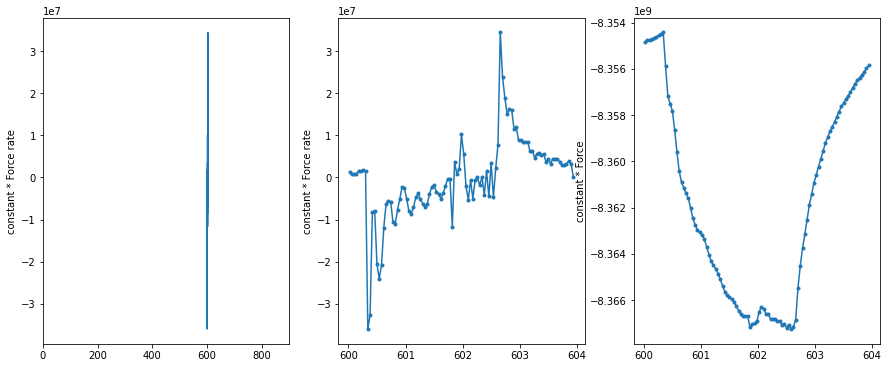

In [281]:
""" Replicating force rate plot up to scaling using left-biased sampling and trapz integration """
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(t_list, force_rate_reduced)
plt.xlim(0, 15*60)
plt.ylabel("constant * Force rate")

plt.subplot(1,3,2)
plt.plot(t_list, force_rate_reduced, '.-')
plt.ylabel("constant * Force rate")
# plt.xlim(0, 15*60)

plt.subplot(1,3,3)
plt.plot(t_list, force_reduced, '.-')
plt.ylabel("constant * Force")


In [284]:
_solver = solver_from(0, 15000)

poly_coefs = np.concatenate([
    compute_poly_coef(
      _solver.elem_helpers.x_elems,
      _solver.state_coeffs[...,i:i+1],
      _solver.mesh.node_coords)
    for i in range(_solver.state_coeffs.shape[-1])],
  axis=-1)

## Part 1: elementwise Gauss quadrature of tau

In [352]:
''' Gauss quadrature of tau(x) * w(x) '''

# Dummy weights, standing in for elastic Green's function
integ_weight = lambda x: np.ones_like(x)

file_idx = 15000

# For each solver
loc_quad_results = []
for solver_idx in range(5):
  _solver = solver_from(solver_idx, file_idx)

  # Limited polynomial coefficients
  poly_coefs = np.concatenate([
      compute_poly_coef(
        _solver.elem_helpers.x_elems,
        _solver.state_coeffs[...,i:i+1],
        _solver.mesh.node_coords)
      for i in range(_solver.state_coeffs.shape[-1])],
    axis=-1)
  poly_coefs = scipy.interpolate.lagrange(
          x_elems[i,:,0].ravel(),
          vals[i,:,0])

  total_integral = 0
  for elt_idx in range(_solver.state_coeffs.shape[0]):
    def drag_repr(x_loc):
      # Reshape
      x_loc = np.asarray(x_loc).ravel()
       # Evaluate drag at vector x_loc within element
      U_loc = np.stack([
        np.polynomial.polynomial.Polynomial(poly_coefs[elt_idx,:,i].ravel())(x_loc)
        for i in range(_solver.state_coeffs.shape[-1])],
        axis=-1)
      # Evaluate drag times integration weight at integration points
      return _solver.physics.compute_additional_variable("Drag",
        np.expand_dims(U_loc, axis=1), False).ravel() * integ_weight(x_loc).ravel()
    # Gauss qaudrature for tau(x) w(x) in element
    loc_quad_results.append(scipy.integrate.quadrature(
      drag_repr,
      _solver.mesh.node_coords[elt_idx,0],
      _solver.mesh.node_coords[elt_idx+1,0]))

# Unpack quadrature values and error estimates
loc_vals, loc_errs = zip(*loc_quad_results)
loc_vals = np.array(loc_vals)
loc_errs = np.array(loc_errs)

# Get global tau for comparison
globaldrag = np.concatenate([_get_from(solver_from(i, file_idx), "Drag") \
     for i in (0,1,2,3,4)], axis=0)

c:\Python39\lib\site-packages\scipy\integrate\_quadrature.py:277: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.096617e+00
  warnings.warn(
c:\Python39\lib\site-packages\scipy\integrate\_quadrature.py:277: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.868021e-01
  warnings.warn(


Text(0.5, 1.0, 'Gauss quadrature error estimate (diff of last two)')

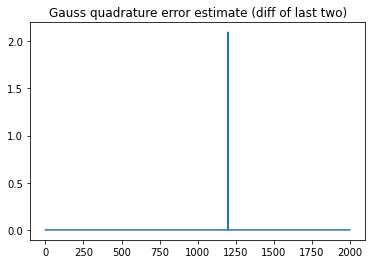

In [366]:
plt.plot(loc_errs)
plt.title("Gauss quadrature error estimate (diff of last two)")

Integration of tau(x) w(x), w(x) = 1 using ...


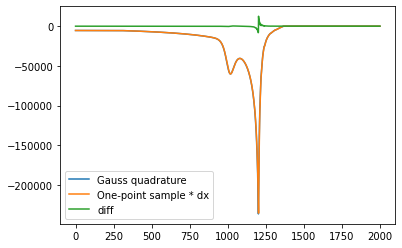

In [369]:
dx = float(_solver.mesh.node_coords[1,:] - _solver.mesh.node_coords[0,:])

plt.plot(loc_vals)
plt.plot(globaldrag[:,0,:].ravel() * dx)
plt.plot(loc_vals - globaldrag[:,0,:].ravel() * dx)
plt.legend(["Gauss quadrature with limiting", "One-point sample * dx", "diff"])
print("Integration of tau(x) w(x), w(x) = 1 using ...")

Integration of tau(x) w(x), w(x) = 1 using ...


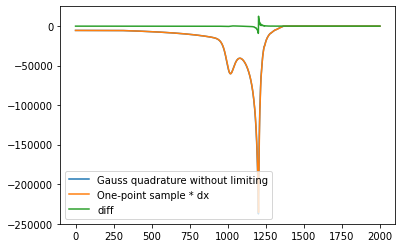

In [438]:
loc_vals_unlim = integrate_squarejac(15000, get_elementwise=True)
plt.plot(loc_vals_unlim)
plt.plot(globaldrag[:,0,:].ravel() * dx)
plt.plot(loc_vals_unlim - globaldrag[:,0,:].ravel() * dx)
plt.legend(["Gauss quadrature without limiting", "One-point sample * dx", "diff"])
print("Integration of tau(x) w(x), w(x) = 1 using ...")

In [378]:
compute_poly_coef(
  _solver.elem_helpers.x_elems,
  _solver.state_coeffs[...,0:1],
  _solver.mesh.node_coords).shape

_poly = scipy.interpolate.lagrange(
  _solver.elem_helpers.x_elems[0,:,0].ravel(),
  _solver.state_coeffs[0,:,0])
_poly

poly1d([4.689783655279119e-11, 1.120909712964968e-08,
       4.188378795788594e-06])

In [386]:
x_loc = [1,2]

x_loc = np.asarray(x_loc).ravel()
# Evaluate drag at vector x_loc within element
U_loc = np.stack([
  scipy.interpolate.lagrange(
    _solver.elem_helpers.x_elems[elt_idx,:,0],
    _solver.state_coeffs[elt_idx,:,i])(x_loc)
  for i in range(_solver.state_coeffs.shape[-1])],
  axis=-1)

In [407]:
dir(_solver.elem_helpers)

['Fq',
 'Sq',
 'Uq',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alloc_other_arrays',
 'basis_phys_grad_elems',
 'basis_ref_grad',
 'basis_val',
 'compute_helpers',
 'djac_elems',
 'domain_vol',
 'face_quad_pts',
 'face_quad_wts',
 'get_basis_and_geom_data',
 'get_gaussian_quadrature',
 'iMM_elems',
 'ijac_elems',
 'jac_elems',
 'need_phys_grad',
 'normals_elems',
 'quad_pts',
 'quad_wts',
 'vol_elems',
 'x_elems']

In [429]:
np.einsum("ijk -> ", Uq), Uq.sum()

(170071999278.44406, 170071999278.44617)

In [414]:
_solver.elem_helpers.basis_val

array([[ 0.687298334620742,  0.4              , -0.087298334620742],
       [-0.               ,  1.               ,  0.               ],
       [-0.087298334620742,  0.4              ,  0.687298334620742]])

In [435]:
''' Gauss quadrature of tau(x) * w(x) '''

# Dummy weights, standing in for elastic Green's function
integ_weight = lambda x: np.ones_like(x)

def integrate_squarejac(file_idx, get_elementwise=False):
  ''' Equal-order classical Gauss quadrature without postprocessing limiter '''
  loc_quad_results = []
  taus = []
  for solver_idx in range(5):
    # Load solver
    _solver = solver_from(solver_idx, file_idx)
    # Map coefficients to polynomial values at quadrature points
    Uq = np.einsum("ij, ljk -> lik",
      _solver.elem_helpers.basis_val,
      _solver.state_coeffs)
    # Evaluate drag at quad points
    tau_loc = _solver.physics.compute_additional_variable("Drag", Uq, False)
    # Elementwise quadrature
    taus.append(np.einsum("ijk, ij, j -> i",
      tau_loc,
      _solver.elem_helpers.jac_elems[:,:,0,0],
      _solver.elem_helpers.quad_wts[:,0]))
  if get_elementwise:
    return np.concatenate(taus, axis=0)
  else:
    return np.concatenate(taus, axis=0).sum()

def integrate_tau(file_idx, get_elementwise=False):
  ''' Integrate tau without postprocessing limiter '''
  loc_quad_results = []
  for solver_idx in range(5):
    # Load solver
    _solver = solver_from(solver_idx, file_idx)
    for elt_idx in range(_solver.state_coeffs.shape[0]):

      def drag_repr(x_loc):
        ''' Evaluate drag using DG representation at vector x_loc '''
        # Reshape
        x_loc = np.asarray(x_loc).ravel()
        # Evaluate drag at vector x_loc within element
        U_loc = np.stack([
          scipy.interpolate.lagrange(
            _solver.elem_helpers.x_elems[elt_idx,:,0],
            _solver.state_coeffs[elt_idx,:,i])(x_loc)
          for i in range(_solver.state_coeffs.shape[-1])],
          axis=-1)
        # Evaluate drag times integration weight at integration points
        return _solver.physics.compute_additional_variable("Drag",
          np.expand_dims(U_loc, axis=1), False).ravel() * integ_weight(x_loc).ravel()
      # Gauss qaudrature for tau(x) w(x) in element
      loc_quad_results.append(scipy.integrate.quadrature(
          drag_repr,
          _solver.mesh.node_coords[elt_idx,0],
          _solver.mesh.node_coords[elt_idx+1,0],
          rtol=1e-5))

  # Unpack quadrature values and error estimates
  loc_vals, loc_errs = zip(*loc_quad_results)
  loc_vals = np.array(loc_vals)
  loc_errs = np.array(loc_errs)
  if get_elementwise:
    return loc_vals
  return loc_vals.sum()
  
def integrate_tau_limiting(file_idx):
  # For each solver
  loc_quad_results = []
  for solver_idx in range(5):
    _solver = solver_from(solver_idx, file_idx)
    poly_coefs = np.concatenate([
        compute_poly_coef(
          _solver.elem_helpers.x_elems,
          _solver.state_coeffs[...,i:i+1],
          _solver.mesh.node_coords)
        for i in range(_solver.state_coeffs.shape[-1])],
      axis=-1)

    total_integral = 0
    for elt_idx in range(_solver.state_coeffs.shape[0]):
      def drag_repr(x_loc):
        # Reshape
        x_loc = np.asarray(x_loc).ravel()
        # Evaluate drag at vector x_loc within element
        U_loc = np.stack([
          np.polynomial.polynomial.Polynomial(poly_coefs[elt_idx,:,i].ravel())(x_loc)
          for i in range(_solver.state_coeffs.shape[-1])],
          axis=-1)
        # Evaluate drag times integration weight at integration points
        return _solver.physics.compute_additional_variable("Drag",
          np.expand_dims(U_loc, axis=1), False).ravel() * integ_weight(x_loc).ravel()
      # Gauss qaudrature for tau(x) w(x) in element
      loc_quad_results.append(scipy.integrate.quadrature(
        drag_repr,
        _solver.mesh.node_coords[elt_idx,0],
        _solver.mesh.node_coords[elt_idx+1,0]))

  # Unpack quadrature values and error estimates
  loc_vals, loc_errs = zip(*loc_quad_results)
  loc_vals = np.array(loc_vals)
  loc_errs = np.array(loc_errs)
  return loc_vals.sum()

In [470]:
t_list = []
drag_pointwise = []
for file_idx in range(15000, 15999):
  globaldrag = np.concatenate([_get_from(solver_from(i, file_idx), "Drag") \
     for i in (0,1,2,3,4)], axis=0)
  drag_pointwise.append(np.trapz(globaldrag[:,0,0].ravel(), x=x_elems[:,0].ravel()))
  _t0 = solver_from(0, file_idx).time
  _t1 = solver_from(0, file_idx+1).time
  t_list.append(0.5*(_t0 + _t1))
drag_pointwise = np.array(drag_pointwise)
t_list = np.array(t_list)

In [469]:
# Basic Gauss quadrature (equal order integration)
drag_quad = [integrate_squarejac(_file_idx) for _file_idx in range(15000, 15999)]
drag_pointwise = force_reduced/ (2 * np.pi \
    * solver1.physics.source_terms[1].conduit_radius)

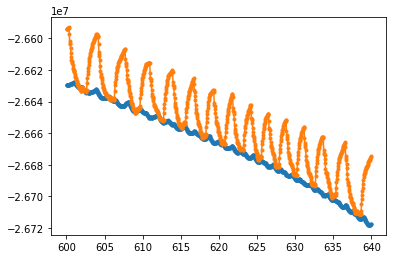

In [471]:
plt.plot(t_list, drag_quad, '.-')
plt.plot(t_list, drag_pointwise, '.-')

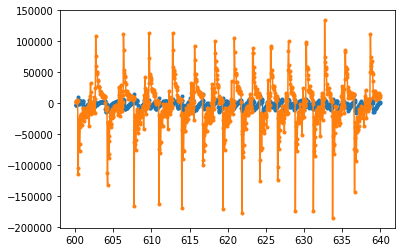

In [472]:
ddt_drag_quad = np.diff(drag_quad) / (t_list[1] - t_list[0])
ddt_drag_pointwise = np.diff(drag_pointwise) / (t_list[1] - t_list[0])
plt.plot(t_list[1:], ddt_drag_quad, '.-')
plt.plot(t_list[1:], ddt_drag_pointwise, '.-')

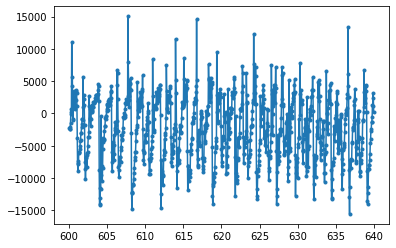

In [473]:
plt.plot(t_list[1:], ddt_drag_quad, '.-')

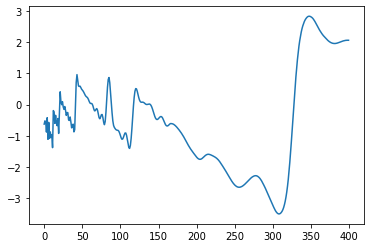

In [489]:
dmomentum = solver_from(3, 15001).state_coeffs[...,0,3:4] - solver_from(3, 15000).state_coeffs[...,0,3:4]
plt.plot(dmomentum)

In [474]:
# Drag elementwise integrals
drag_quad_elementwise = np.array([
  integrate_squarejac(_file_idx, get_elementwise=True)
  for _file_idx in range(15000, 15999)])

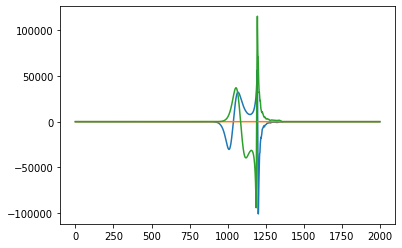

In [483]:
plt.plot(drag_quad_elementwise[0,:]-drag_quad_elementwise[500,:])
plt.plot(drag_quad_elementwise[500,:]-drag_quad_elementwise[500,:])
plt.plot(drag_quad_elementwise[998,:]-drag_quad_elementwise[500,:])


C:\Users\Fredric\AppData\Local\Temp\ipykernel_20552\3063151793.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogy(np.abs(drag_quad_elementwise[501,:] / drag_quad_elementwise[500,:] - 1))


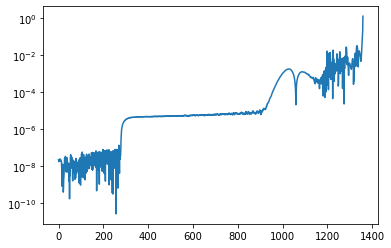

In [482]:
plt.semilogy(np.abs(drag_quad_elementwise[501,:] / drag_quad_elementwise[500,:] - 1))
# plt.plot(drag_quad_elementwise[501,:])


## Part 2: chain rule evaluation of d/dt (drag) using the PDE residual

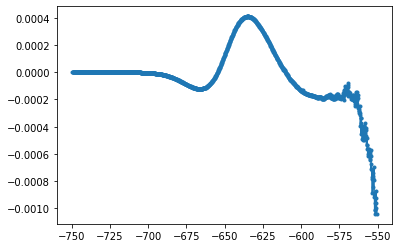

In [552]:
plt.plot(solver1.elem_helpers.x_elems[1:-1,...].ravel(),
  numerical_res[1:-1,...,3:4].ravel(), '.-')

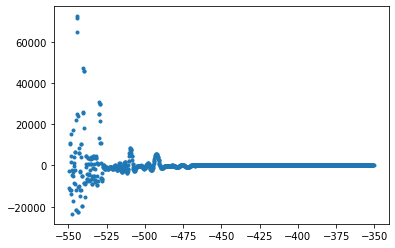

In [554]:
h_unscaled = 1e-7

solver1 = solver_from(3, 15000)

# Estimate state gradient of drag
dU = np.empty_like(solver1.state_coeffs)
scale = np.array([1e-6,1,1,1,1e8,1,1,1])
sjac = np.zeros((*solver1.state_coeffs.shape[:2], 1, 8))

for i in range(solver1.state_coeffs.shape[-1]):
  # Elementwise central difference
  dU[:] = 0
  h = h_unscaled * scale[i]
  dU[...,i] = h
  drag_plus = solver1.physics.compute_additional_variable("Drag", solver1.state_coeffs + dU, False)
  drag_minus = solver1.physics.compute_additional_variable("Drag", solver1.state_coeffs - dU, False)
  sjac[...,i] = (drag_plus - drag_minus)/(2*h)

# Compute chain rule drag
U = solver1.state_coeffs.copy()
res = np.zeros_like(U)
# Get residual without boundary_face_residuals
solver1.get_element_residuals(U, res)
solver1.get_interior_face_residuals(U, res)
numerical_res = solver_tools.mult_inv_mass_matrix(solver1.mesh, solver1, solver1.stepper.dt, res)
# Compute local d/dt of the drag source term
ddt_drag = np.einsum("ijkl, ijl -> ij", sjac, (numerical_res/solver1.stepper.dt))
# Plot, truncating boundary-adjacent elements
plt.plot(solver1.elem_helpers.x_elems[1:-1].ravel(), ddt_drag[1:-1].ravel(), '.')

Text(0.5, 1.0, 'Forward difference time-derivative')

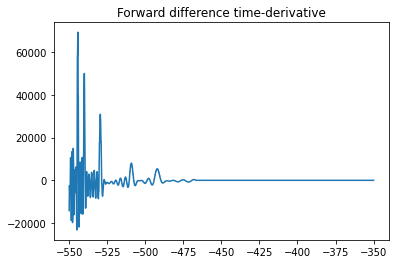

In [555]:
# Compare to d/dt numerically
solver2 = solver_from(3, 15001)
dt = solver2.time - solver1.time

drag2 = solver2.physics.compute_additional_variable("Drag", solver2.state_coeffs, False)
drag1 = solver1.physics.compute_additional_variable("Drag", solver1.state_coeffs, False)
ddt_drag_est = (drag2 - drag1)/dt
plt.plot(solver1.elem_helpers.x_elems.ravel(), ddt_drag_est.ravel())
plt.title("Forward difference time-derivative")

(-550.0, -510.0)

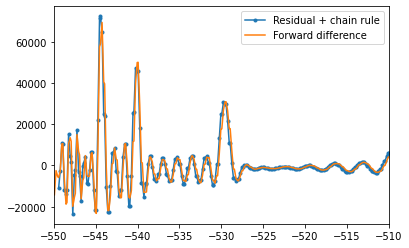

In [558]:
''' Comparison '''

plt.plot(solver1.elem_helpers.x_elems[1:-1].ravel(), ddt_drag[1:-1].ravel(), '.-')
plt.plot(solver1.elem_helpers.x_elems.ravel(), ddt_drag_est.ravel())
plt.legend(["Residual + chain rule", "Forward difference"])
plt.xlim(-550,-510)
# plt.xlim(right=-510)
# plt.xlim(-600,-550)

(-550.0, -510.0)

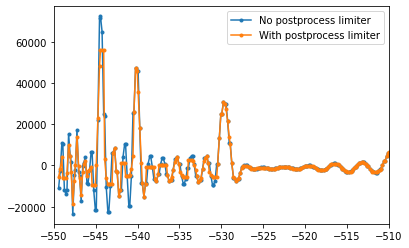

In [560]:
# Put limiter
_lim_poly_coef = compute_poly_coef(
  solver1.elem_helpers.x_elems,
  np.expand_dims(ddt_drag,axis=-1),
  solver1.mesh.node_coords,
  limiting_factor=1.0)

ddt_drag_limited = eval_soln_limited(solver1.elem_helpers.x_elems,
  _lim_poly_coef,
  solver1.mesh.node_coords)

plt.plot(solver1.elem_helpers.x_elems[1:-1].ravel(), ddt_drag[1:-1].ravel(), '.-')
plt.plot(solver1.elem_helpers.x_elems[1:-1].ravel(), ddt_drag_limited[1:-1].ravel(), '.-')
plt.legend(["No postprocess limiter", "With postprocess limiter"])
plt.xlim(-550,-510)


In [685]:
h_unscaled = 1e-7
scale = np.array([1e-6,1,1,1,1e8,1,1,1])

def integrate_residual_ddt(file_idx, get_elementwise=False, get_debug=False):
  ''' Equal-order classical Gauss quadrature without postprocessing limiter '''
  loc_quad_results = []
  taus = []
  debugs_dtaudt_contributions = []
  debugs_sjacs = []
  debugs_dUdt = []
  for solver_idx in range(5):
    # Load solver
    _solver = solver_from(solver_idx, file_idx)
    # Map coefficients to polynomial values at quadrature points
    Uq = np.einsum("ij, ljk -> lik",
      _solver.elem_helpers.basis_val,
      _solver.state_coeffs)

    # Estimate state-gradient of drag
    dU = np.empty_like(_solver.state_coeffs)
    sjac = np.zeros((*_solver.state_coeffs.shape[:2], 1, 8))
    for i in range(_solver.state_coeffs.shape[-1]):
      # Elementwise central difference
      dU[:] = 0
      h = h_unscaled * scale[i]
      dU[...,i] = h
      drag_plus = _solver.physics.compute_additional_variable("Drag", _solver.state_coeffs + dU, False)
      drag_minus = _solver.physics.compute_additional_variable("Drag", _solver.state_coeffs - dU, False)
      sjac[...,i] = (drag_plus - drag_minus)/(2*h)
    # Compute chain rule drag
    U = _solver.state_coeffs.copy()
    res = np.zeros_like(U)
    # Get residual without boundary_face_residuals
    _solver.get_element_residuals(U, res)
    _solver.get_interior_face_residuals(U, res)
    # HACK: boundary residual extrapolation
    res[0] = res[1]
    res[-1] = res[-2]
    numerical_res = solver_tools.mult_inv_mass_matrix(_solver.mesh, _solver, _solver.stepper.dt, res)

    # U += numerical_res
    # solver.order, _temp = 1, solver.order
    # solver.apply_limiter(U)
    # solver.order = _temp
    # # Re-evaluate actual change after limiting
    # numerical_res = U - _solver.state_coeffs

    # Compute local d/dt of the drag source term
    ddt_drag = np.einsum("ijkl, ijl -> ijk", sjac, (numerical_res/_solver.stepper.dt))

    # Evaluate drag at quad points
    # tau_loc = _solver.physics.compute_additional_variable("Drag", Uq, False)
    # Elementwise quadrature
    taus.append(np.einsum("ijk, ij, j -> i",
      ddt_drag,
      _solver.elem_helpers.jac_elems[:,:,0,0],
      _solver.elem_helpers.quad_wts[:,0]))
    debugs_dtaudt_contributions.append(np.einsum("ijkl, ijl -> ijkl", sjac, (numerical_res/_solver.stepper.dt)))
    debugs_sjacs.append(sjac)
    debugs_dUdt.append(numerical_res/_solver.stepper.dt)
  if get_debug:
    return (np.concatenate(taus, axis=0),
      debugs_dtaudt_contributions,
      debugs_sjacs,
      debugs_dUdt)
  if get_elementwise:
    return np.concatenate(taus, axis=0)
  else:
    return np.concatenate(taus, axis=0).sum()

In [600]:
_solver.params["ArtificialViscosity"]

True

In [590]:
xL = solver_from(0, 15000).mesh.node_coords[0]
xR = solver_from(4, 15000).mesh.node_coords[0]
N_elt = 5*(solver_from(0, 15000).mesh.node_coords.shape[0]-1)
x_elt_global = np.linspace(xL, xR, N_elt)

In [617]:
sgrad_drag_sens = integrate_residual_ddt(15500, get_elementwise=True, get_debug=True)[1]

In [616]:
integrate_residual_ddt(15500, get_elementwise=True, get_debug=True)

In [624]:
sgrad_drag_sens = np.concatenate(sgrad_drag_sens, axis=0)
# .min()

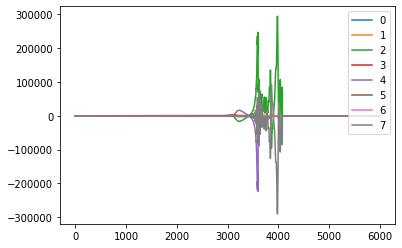

In [626]:
for i in range(8):
  plt.plot(sgrad_drag_sens[...,i].ravel())
plt.legend(np.arange(8))

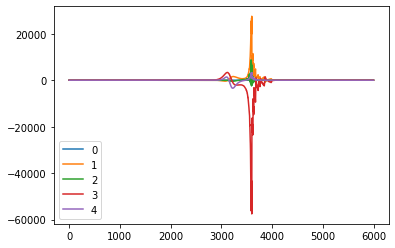

In [638]:
for i in [0, 1, 3, 5, 6, ]:
  plt.plot(sgrad_drag_sens[...,i].ravel())
plt.legend(np.arange(8))

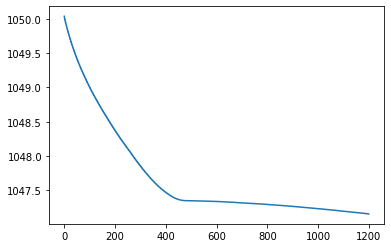

In [639]:
plt.plot(solver_from(3, 15501).physics.compute_variable("Temperature", solver_from(3, 15501).state_coeffs).ravel())

In [657]:
yi = solver_from(3, 15501).state_coeffs[...,0:3] / solver_from(3, 15501).state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
ypassivei = solver_from(3, 15501).state_coeffs[...,5:] / solver_from(3, 15501).state_coeffs[...,0:3].sum(axis=-1, keepdims=True)

rho = solver_from(3, 15501).state_coeffs[...,0:3].sum(axis=-1, keepdims=True)

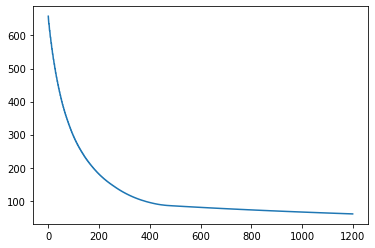

In [653]:
plt.plot(rho.ravel())

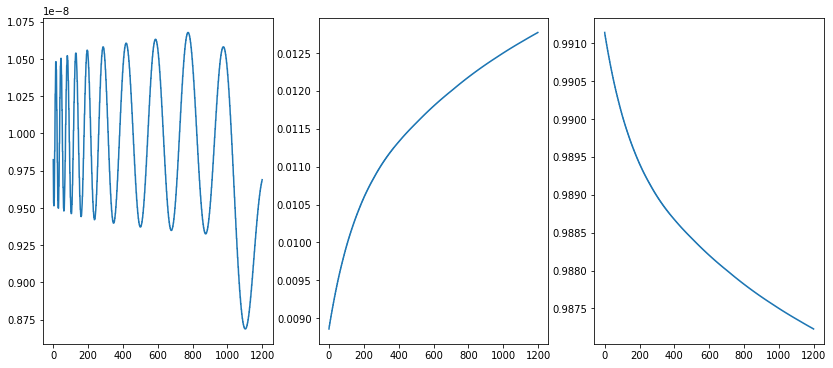

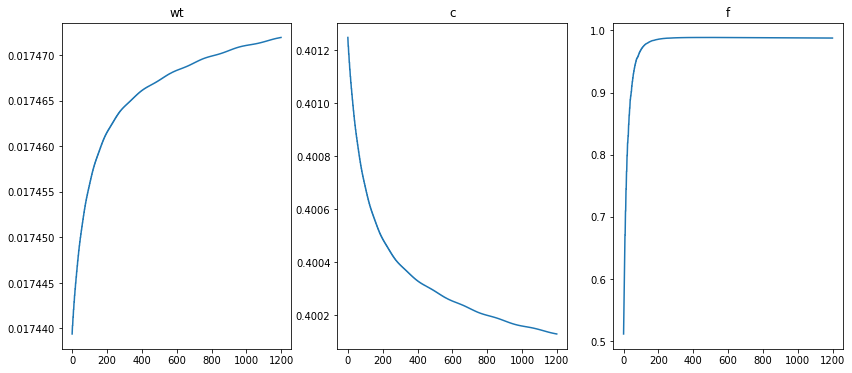

In [660]:
plt.figure(figsize=(14,6))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(yi[...,i].ravel())

plt.figure(figsize=(14,6))
entries=["wt", "c", "f"]
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(ypassivei[...,i].ravel())
  plt.title(entries[i])

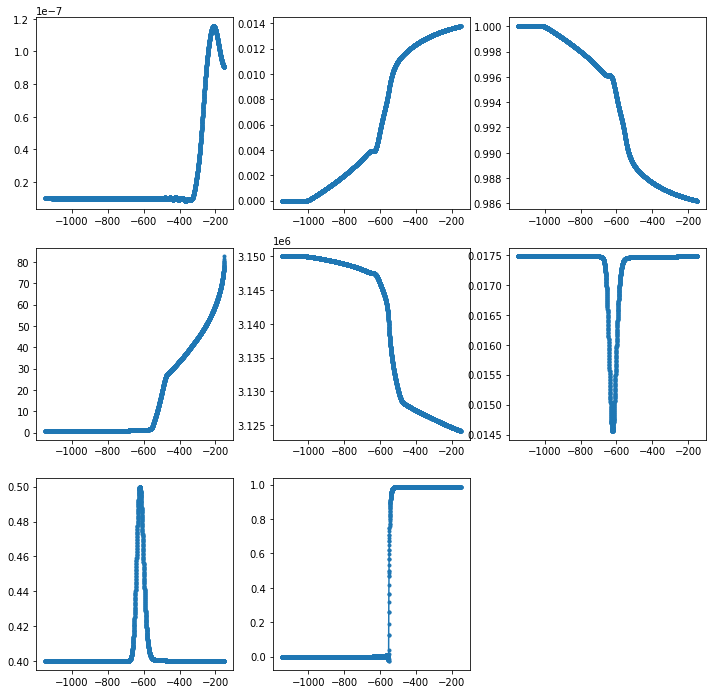

In [669]:
def get_from(file_idx, field_name=None):
  U = np.concatenate([solver_from(i, file_idx).state_coeffs for i in range(5)], axis=0)
  x = np.concatenate([solver_from(i, file_idx).elem_helpers.x_elems for i in range(5)], axis=0)
  # Return field is specified, else state_coeffs
  y = solver_from(0, file_idx).physics.compute_additional_variable(
    field_name, U, False
  ) if field_name is not None else U
  return x, y

x, p = get_from(15500, "Pressure")
_, U = get_from(15500)
rho = U[...,0:3].sum(axis=-1, keepdims=True)
# Compute mass-specific quantities: [yA, yWv, yM, u, e, yWt, yC, yFm]
Y = U/rho

plt.figure(figsize=(12,12))
for i in range(8):
  plt.subplot(3,3,i+1)
  plt.plot(x.ravel(), Y[..., i:i+1].ravel(), '.-')


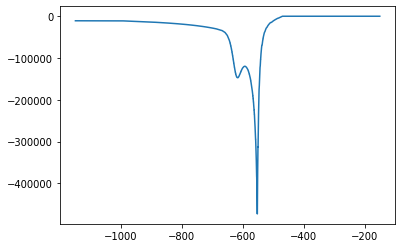

In [706]:
x, tau = get_from(15500, "Drag")
plt.plot(x.ravel(), tau.ravel())

In [713]:
ddragdt.shape, .shape

((2000,), (2000, 3, 1))

In [723]:
integ_drag.shape

(2000,)

In [ ]:
# Rudimentary front detection
file_idx
x.ravel(), get_from(15500, "phi")[1].ravel()

In [751]:
crit_volfrac_level = [
  x.ravel()[np.argmax(get_from(file_idx, "phi")[1].ravel() >= 0.8)]
  for file_idx in range(15000,15999)]

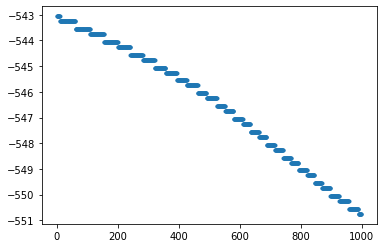

In [753]:
plt.plot(crit_volfrac_level, '.')

(-600.0, -525.0)

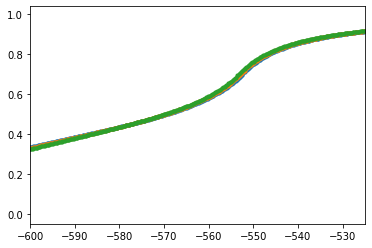

In [746]:
plt.plot(x.ravel(), get_from(15500, "phi")[1].ravel(), '.-')
plt.plot(x.ravel(), get_from(15550, "phi")[1].ravel(), '.-')
plt.plot(x.ravel(), get_from(15600, "phi")[1].ravel(), '.-')
plt.xlim(-600,-525)

In [747]:
solver_from(0, 15500).physics.source_terms[1].crit_volfrac

0.8

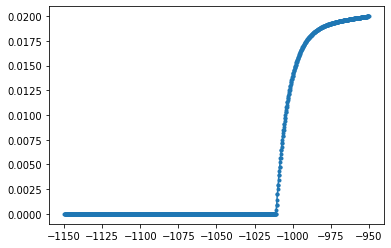

In [743]:
# Solubility
source_exsol = solver_from(0, 15500).physics.source_terms[2].get_source(
  solver_from(0, 15500).physics,
  solver_from(0, 15500).state_coeffs,
  solver_from(0, 15500).elem_helpers.x_elems,
  solver_from(0, 15500).time,
)
plt.plot(solver_from(0, 15500).elem_helpers.x_elems.ravel(), source_exsol[...,1:2].ravel(), '.-')

Text(0.5, 1.0, 't = 619.999999934733')

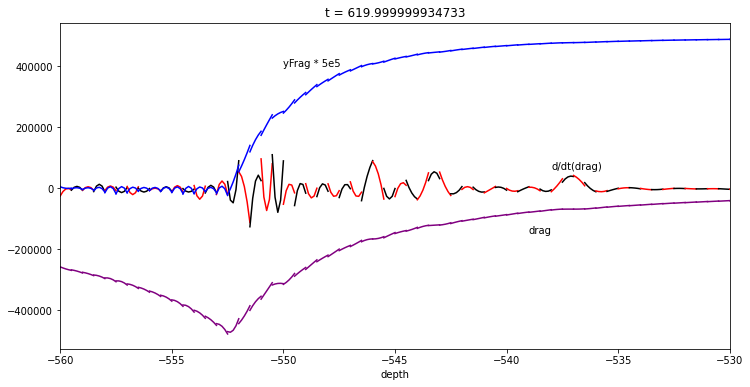

In [820]:
%matplotlib inline

def plot_DGsoln(x_elems, vals, node_coords, colorcycle):
  ''' Plots piecewise polynomial solution. Uses a built-in x-axis. '''
  for elt_idx in range(x_elems.shape[0]):
    # Define points in current element to plot at
    x_loc = np.linspace(node_coords[elt_idx], node_coords[elt_idx+1], 5)
    # Define the local polynomial representation of vals
    _poly = scipy.interpolate.lagrange(
      x_elems[elt_idx,:,0].ravel(),
      vals[elt_idx,:,0])
    # Add plotz
    plt.plot(x_loc, _poly(x_loc), '-',
             color=colorcycle[elt_idx % len(colorcycle)])

plt.figure(figsize=(12,6))
# Global node coords
node_coords = np.concatenate([solver_from(i, 15500).mesh.node_coords[:-1,...]
                              for i in range(5)] +
                                [solver_from(4, 15500).mesh.node_coords[-1:,...]],
                              axis=0)

plot_DGsoln(x_elems, ddragdt, node_coords, ["red", "black"])
plot_DGsoln(x_elems, 500000*Y[...,7:8], node_coords, ["blue"])
plot_DGsoln(x_elems, tau, node_coords, ["purple"])

if False:
  # Plot d/dt
  plt.plot(x.ravel(), ddragdt.ravel())
  # Element average (divide by |jac|)
  # plt.plot(x[:,1].ravel(), integ_drag.ravel()/ 0.5, '--')
  # Plot magnified fragment content
  plt.plot(x.ravel(), 500000*Y[...,7].ravel())
  # Plot tau
  plt.plot(x.ravel(), tau.ravel())

plt.xlim(-560,-530)
# plt.xlim(-600,-450)

plt.text(-550, 400000, "yFrag * 5e5")
plt.text(-538, 60000, "d/dt(drag)")
plt.text(-539, -150000, "drag")
plt.xlabel("depth")
plt.title(f"t = {solver_from(i, 15500).time}")

In [ ]:
%matplotlib inline

def plot_DGsoln(x_elems, vals, node_coords, colorcycle):
  ''' Plots piecewise polynomial solution. Uses a built-in x-axis. '''
  for elt_idx in range(x_elems.shape[0]):
    # Define points in current element to plot at
    x_loc = np.linspace(node_coords[elt_idx], node_coords[elt_idx+1], 5)
    # Define the local polynomial representation of vals
    _poly = scipy.interpolate.lagrange(
      x_elems[elt_idx,:,0].ravel(),
      vals[elt_idx,:,0])
    # Add plotz
    plt.plot(x_loc, _poly(x_loc), '-',
             color=colorcycle[elt_idx % len(colorcycle)])

plt.figure(figsize=(12,6))
# Global node coords
node_coords = np.concatenate([solver_from(i, 15500).mesh.node_coords[:-1,...]
                              for i in range(5)] +
                                [solver_from(4, 15500).mesh.node_coords[-1:,...]],
                              axis=0)

plot_DGsoln(x_elems, ddragdt, node_coords, ["red"])
plot_DGsoln(x_elems, 500000*Y[...,7:8], node_coords, ["blue"])

if False:
  # Plot d/dt
  plt.plot(x.ravel(), ddragdt.ravel())
  # Element average (divide by |jac|)
  # plt.plot(x[:,1].ravel(), integ_drag.ravel()/ 0.5, '--')
  # Plot magnified fragment content
  plt.plot(x.ravel(), 500000*Y[...,7].ravel())
  # Plot tau
  plt.plot(x.ravel(), tau.ravel())

plt.xlim(-560,-530)
# plt.xlim(-600,-450)

plt.text(-550, 400000, "yFrag * 5e5")
plt.text(-538, 60000, "d/dt(drag)")
plt.text(-539, -150000, "drag")
plt.xlabel("depth")
plt.title(f"t = {solver_from(i, 15500).time}")

In [811]:
i = 0
_x_test , _drag1_test = get_from(15500, "Drag")
_ , _drag2_test = get_from(15501, "Drag")
dt = solver_from(0, 15501).time - solver_from(0, 15500).time

In [812]:
_ddragdt_test = (_drag2_test - _drag1_test) / dt

(-560.0, -530.0)

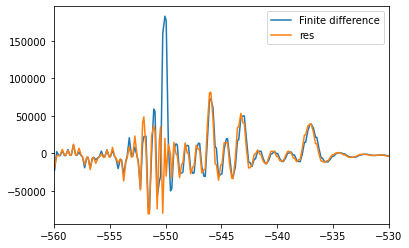

In [819]:
''' Compared finite difference, residual '''
plt.plot(_x_test.ravel(), _ddragdt_test.ravel())
plt.plot(x.ravel(), ddragdt.ravel())
plt.legend(["Finite difference", "res"])
plt.xlim(-700,-500)
plt.xlim(-560,-530)


In [805]:
x_elems.shape, ddragdt.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [781]:
%matplotlib tk
plt.plot(x.ravel(), tau.ravel(), '.')
plt.xlim(-570,-500)


(-570.0, -500.0)

In [720]:
integ_drag, sgrad_drag_sens, sjacs, dUdt = integrate_residual_ddt(15500, get_elementwise=True, get_debug=True)
ddragdt= np.concatenate(sgrad_drag_sens,axis=0).sum(axis=-1)
sjacs = np.concatenate(sjacs, axis=0)
dUdt = np.concatenate(dUdt, axis=0)


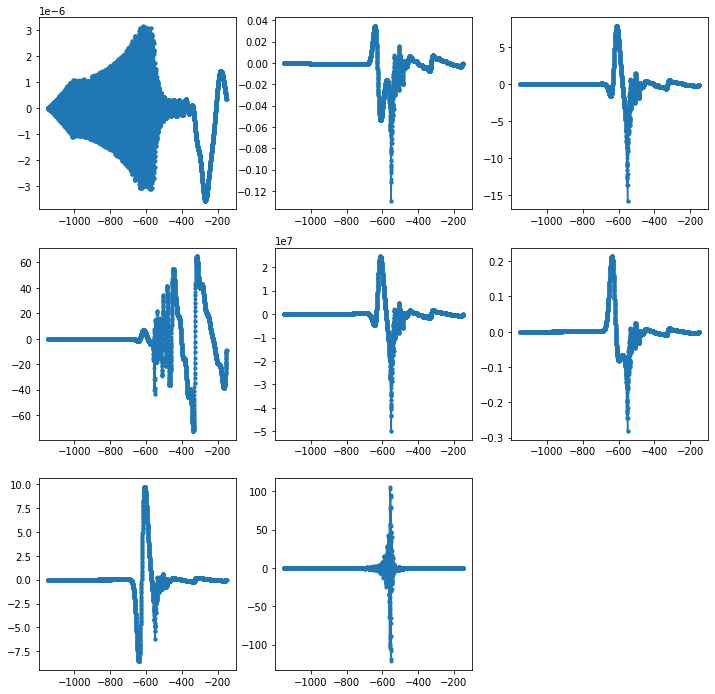

In [696]:
%matplotlib inline
plt.figure(figsize=(12,12))
for i in range(8):
  plt.subplot(3,3,i+1)
  plt.plot(x.ravel(), dUdt[..., i:i+1].ravel(), '.-')

Text(0, 0.5, 'du/dt')

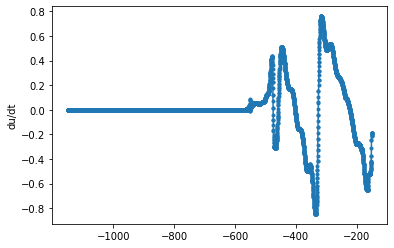

In [704]:
plt.plot(x.ravel(), (dUdt[..., 3:4] / rho - U[..., 3:4] * dUdt[..., 0:3].sum(axis=-1, keepdims=True) / (rho*rho) ).ravel(), '.-')
# plt.xlim(-700,-600)
# plt.ylim(1,1.1)
plt.ylabel("du/dt")

In [682]:
plt.plot(x.ravel(), rho[..., 0].ravel(), '.-')
# plt.plot(np.diff(rho.ravel()), '.-')
plt.xlim(-700,-600)
plt.ylim(1500,2300)

(1500.0, 2300.0)

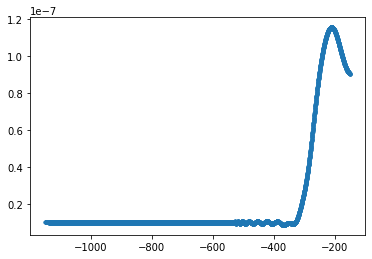

In [670]:
plt.plot(x.ravel(), Y[..., 0].ravel(), '.-')

In [ ]:
# Partial pressure of air

In [ ]:
plt.plot(solver_from(3, 15501).physics.compute_variable("Temperature", solver_from(3, 15501).state_coeffs).ravel())


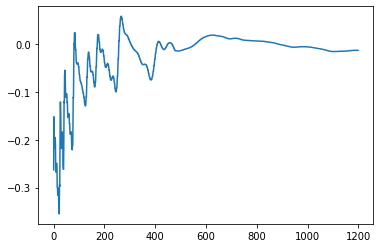

In [628]:
''' arhoM diff: most sensitive '''
plt.plot(solver_from(3, 15501).state_coeffs[...,2].ravel() - solver_from(3, 15500).state_coeffs[...,2].ravel())

Text(0, 0.5, 'd/dt(drag)')

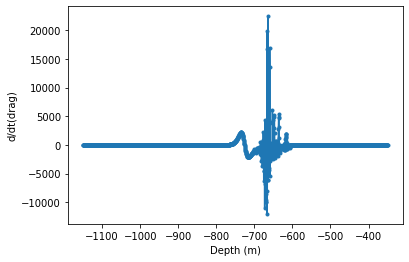

In [802]:
plt.plot(x_elt_global, integrate_residual_ddt(15500, get_elementwise=True), '.-')
plt.xlabel("Depth (m)")
plt.ylabel("d/dt(drag)")
# plt.xlim(-680,-630)

In [588]:
np.concatenate(taus, axis=0)

NameError: name 'taus' is not defined

In [ ]:

solver1 = solver_from(3, 15000)




# Plot, truncating boundary-adjacent elements
plt.plot(solver1.elem_helpers.x_elems[1:-1].ravel(), ddt_drag[1:-1].ravel(), '.')